In [4]:
import time

from pythonbpf import bpf, map, section, bpfglobal, BPF
from pythonbpf.helper import pid
from pythonbpf.maps import HashMap
from ctypes import c_void_p, c_int64, c_uint64, c_int32
import matplotlib.pyplot as plt

In [5]:
@bpf
@map
def hist() -> HashMap:
    return HashMap(key=c_int32, value=c_uint64, max_entries=4096)


@bpf
@section("tracepoint/syscalls/sys_enter_clone")
def hello(ctx: c_void_p) -> c_int64:
    process_id = pid()
    one = 1
    prev = hist.lookup(process_id)
    if prev:
        previous_value = prev + 1
        print(f"count: {previous_value} with {process_id}")
        hist.update(process_id, previous_value)
        return c_int64(0)
    else:
        hist.update(process_id, one)
    return c_int64(0)


@bpf
@bpfglobal
def LICENSE() -> str:
    return "GPL"


b = BPF()

Recording


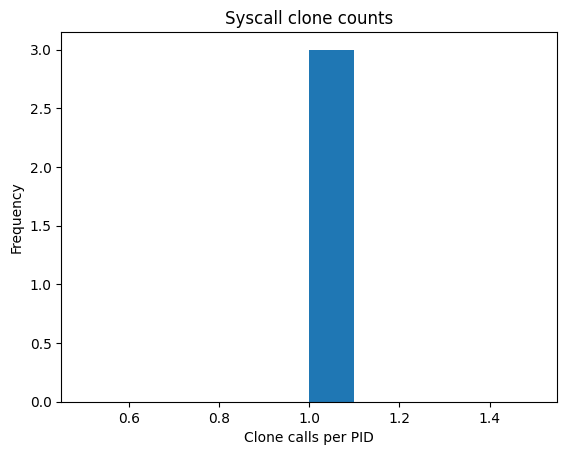

In [6]:
b.load()
b.attach_all()
print("Recording")
time.sleep(10)

counts = list(b["hist"].values())

plt.hist(counts, bins=10)
plt.xlabel("Clone calls per PID")
plt.ylabel("Frequency")
plt.title("Syscall clone counts")
plt.show()